In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [90]:
raw_df = pd.read_csv("../data/huckleberry_05sep2024.csv", parse_dates=["Start", "End"])
raw_df.columns = [col.lower() for col in raw_df.columns]
raw_df["duration"] = raw_df["end"] - raw_df["start"]
raw_df["duration_minutes"] = raw_df["duration"].dt.seconds / 60
# Remove first and last days
# raw_df = raw_df[(raw_df["start"].dt.date > datetime.date(2024, 7, 26)) & (raw_df["end"].dt.date < datetime.date(2024, 9, 4))]
raw_df = raw_df[(raw_df["start"].dt.date > datetime.date(2024, 8, 15)) & (raw_df["end"].dt.date < datetime.date(2024, 9, 4))]
raw_df = raw_df.sort_values("start")
raw_df = raw_df.drop_duplicates()

In [91]:
raw_df["start_date"] = raw_df["start"].dt.date
raw_df["start_time"] = raw_df["start"].dt.time
raw_df["end_date"] = raw_df["end"].dt.date
raw_df["end_time"] = raw_df["end"].dt.time

In [92]:
raw_df["start_date"].nunique()

19

In [93]:
# Break around the 24hour mark
across_midnight = raw_df.query("type=='Sleep' and start_date != end_date")
new_entries = []
for i, row in across_midnight.iterrows():
    bef_row = row.copy()
    bef_row["end"] = datetime.datetime(year=row["start"].year, month=row["start"].month, day=row["start"].day, hour=23, minute=59, second=59)
    bef_row["duration"] = bef_row["end"] - bef_row["start"]
    bef_row["duration_minutes"] = bef_row["duration"].seconds / 60
    bef_row["start_date"] = bef_row["start"].date()
    bef_row["start_time"] = bef_row["start"].time()
    bef_row["end_date"] = bef_row["end"].date()
    bef_row["end_time"] = bef_row["end"].time()
    new_entries.append(bef_row)
    
    aft_row = row.copy()
    aft_row["start"] = datetime.datetime(year=row["end"].year, month=row["end"].month, day=row["end"].day)
    aft_row["duration"] = aft_row["end"] - aft_row["start"]
    aft_row["duration_minutes"] = aft_row["duration"].seconds / 60
    aft_row["start_date"] = aft_row["start"].date()
    aft_row["start_time"] = aft_row["start"].time()
    aft_row["end_date"] = aft_row["end"].date()
    aft_row["end_time"] = aft_row["end"].time()
    new_entries.append(aft_row)
    
df = (
    pd.concat(
        [
            raw_df.query("not (type=='Sleep' and start_date != end_date)"), 
            pd.DataFrame(new_entries),
        ]
    )
    .reset_index(drop=True)
    .sort_values("start")
)

In [94]:
sdf = df.query("type=='Sleep'")

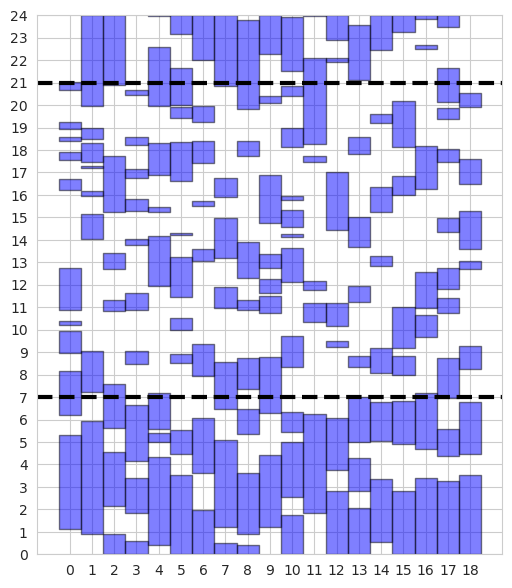

In [99]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from datetime import timedelta

fg, ax = plt.subplots(figsize=(6, 7))

# Loop over data points; create box from errors at each point
rectangles = [
    Rectangle(
        (
            row["start_date"].timetuple().tm_yday, 
            row["start_time"].hour * 60 + row["start_time"].minute,
        ),
        1, 
        row["duration_minutes"],
    )
    for idx, row in sdf.iterrows()
]
pc = PatchCollection(rectangles, facecolor="blue", alpha=0.5, ec="k")
ax.add_collection(pc)
ax.plot()

min_day = sdf["start_date"].values.min().timetuple().tm_yday
max_day = sdf["start_date"].values.max().timetuple().tm_yday
ax.set_xticks(np.arange(max_day-min_day+1) + min_day + 0.5)
ax.set_xticklabels(np.arange(max_day-min_day+1))
ax.set_yticks(np.arange(25) * 60);
ax.set_yticklabels(np.arange(25));
ax.set_ylim([0, 24*60])
ax.axhline([7*60], color="k", ls="--", lw=3)
ax.axhline([21*60], color="k", ls="--", lw=3);

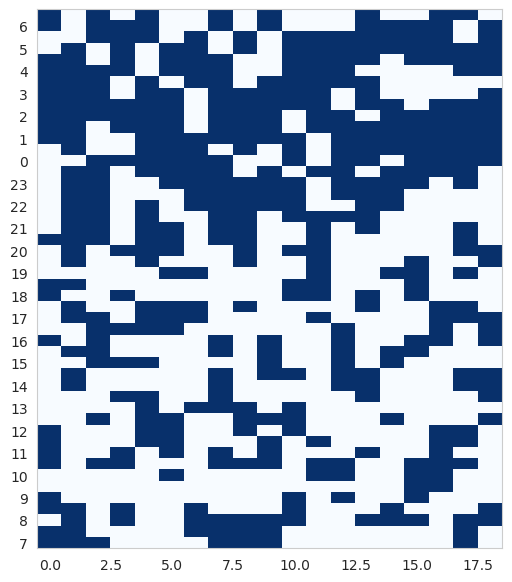

In [102]:
# Wide format
min_day = sdf["start_date"].values.min().timetuple().tm_yday
max_day = sdf["end_date"].values.max().timetuple().tm_yday
nday = (max_day - min_day) + 1
hour_bins = 2
day_bins = 24*hour_bins
roll = -7

wide = np.zeros((nday, day_bins), dtype=bool)
for idx, row in sdf.iterrows():
    day = row["start_date"].timetuple().tm_yday - min_day
    start_bin = int(row["start_time"].hour * hour_bins + row["start_time"].minute // (60 / hour_bins))
    end_bin = int(row["end_time"].hour * hour_bins + (row["end_time"].minute + 1) // (60 / hour_bins))
    wide[day, start_bin: end_bin] = True

fig, ax = plt.subplots(figsize=(6, 7))
ax.imshow(np.roll(wide.T, (roll * hour_bins), axis=0), cmap="Blues", interpolation="nearest", aspect="auto");
ax.set_yticks(np.arange(day_bins)[::hour_bins])
ax.set_yticklabels(np.roll(np.arange(24), roll))
ax.invert_yaxis()
ax.grid(False)
0;

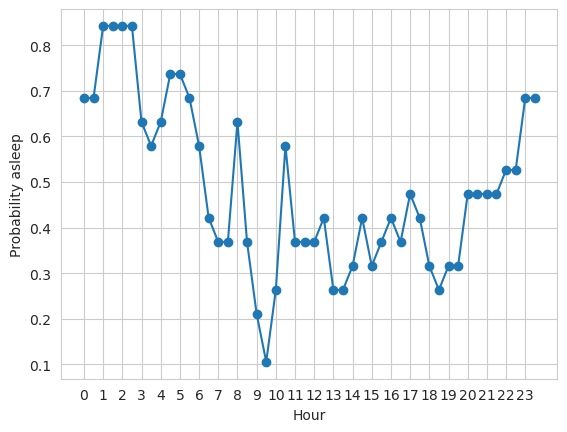

In [103]:
plt.plot(np.roll(wide.mean(0), 0), marker="o")
plt.xticks(np.arange(day_bins)[::hour_bins], np.roll(np.arange(24), 0));
# plt.axvspan(17* hour_bins, 18 * hour_bins, alpha=0.1)
plt.ylabel("Probability asleep")
plt.xlabel("Hour");

Text(0, 0.5, 'Average sleep duration (hours)')

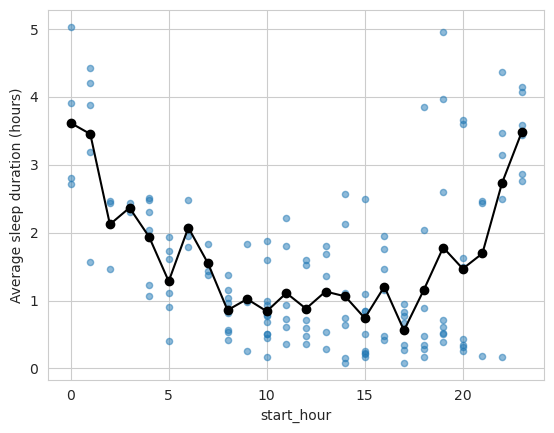

In [104]:
raw_sdf = raw_df.query("type=='Sleep'").copy()
plt.scatter(raw_sdf["start"].dt.hour, raw_sdf["duration_minutes"] / 60, s=20, alpha=0.5)

raw_sdf.loc[:, "start_hour"] = raw_sdf["start"].dt.hour
(raw_sdf.groupby("start_hour")["duration_minutes"].mean() / 60).plot(marker="o", c="k")
plt.ylabel("Average sleep duration (hours)")

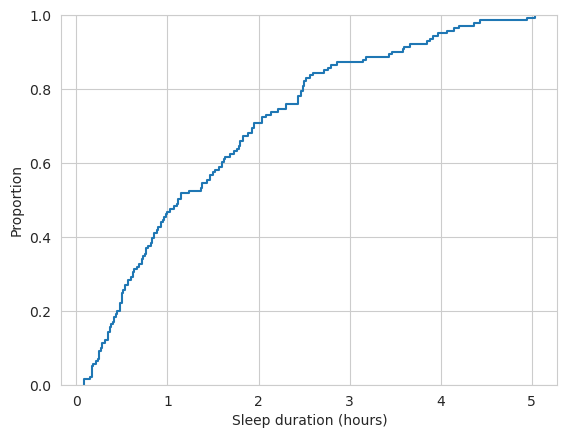

In [105]:
ax = sns.ecdfplot(raw_sdf["duration"].dt.seconds / 60 / 60)
ax.set_xlabel("Sleep duration (hours)");

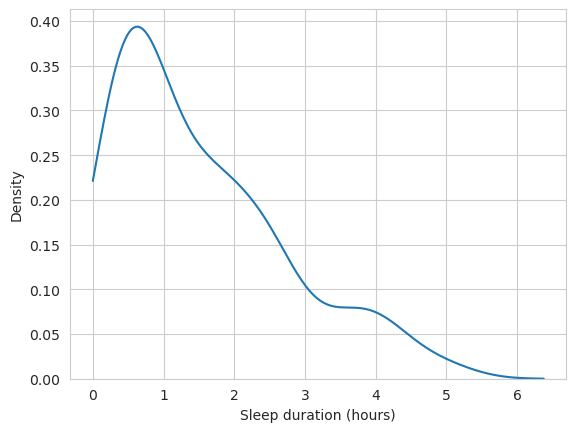

In [106]:
ax = sns.kdeplot((raw_sdf["duration"].dt.seconds / 60 / 60), clip=(0, None))
ax.set_xlabel("Sleep duration (hours)");

In [107]:
raw_sdf.loc[:, "prev_end"] = raw_sdf["end"].shift()
raw_sdf.loc[:, "sleep_gap"] = raw_sdf["start"] - raw_sdf["prev_end"]

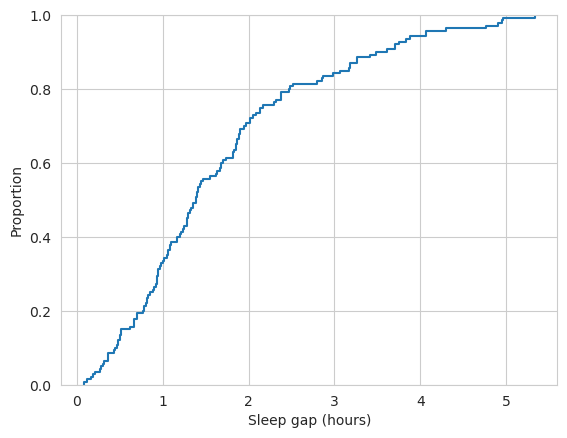

In [108]:
ax = sns.ecdfplot(raw_sdf["sleep_gap"].dt.seconds / 60 / 60)
ax.set_xlabel("Sleep gap (hours)");

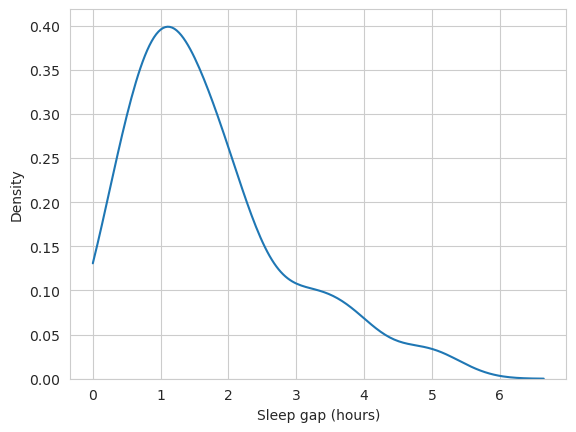

In [109]:
ax = sns.kdeplot((raw_sdf["sleep_gap"].dt.seconds / 60 / 60), clip=(0, None))
ax.set_xlabel("Sleep gap (hours)");

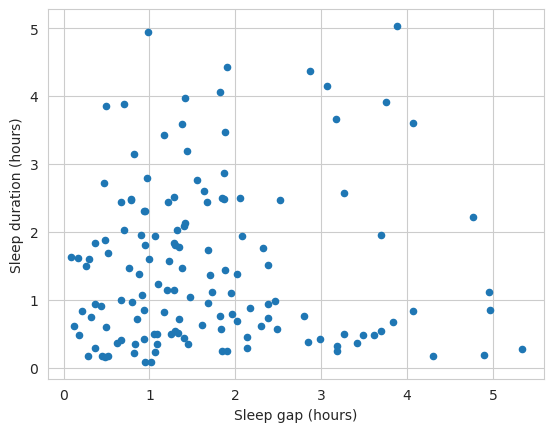

In [110]:
plt.scatter(raw_sdf["sleep_gap"].dt.seconds / 60 / 60, raw_sdf["duration"].dt.seconds / 60 / 60, s=20)
plt.xlabel("Sleep gap (hours)")
plt.ylabel("Sleep duration (hours)");